# July 26th, 2022 Historic Flash Flooding in St. Louis

- https://storymaps.arcgis.com/stories/9d10335079444c159966e0a28c90c4df

## Introduction


- In this activity, we'll explore the process of extracting raster data from sources like NWS, landcover, SAR data, DEM, and its related derivatives. 
- We'll then transform these layers into a structured tabular format. 
- With the data in this form, we'll be equipped to train a model in BigQuery to anticipate flood-prone zones. 
- This will enable us to forecast flooded areas, and generate comprehensive reports detailing the impact on populations and infrastructure.

## Setup

### Environment

Clone Repo from https://github.com/lanzij-oci/flood-bq-model.git

For this Jupyter notebook to work, the user must set up the proper environment:

```
pip install -r requirements.txt
```

These steps will install all python modules required for this notebook

### Authentication

Setup Instructions were sent to participants prior to this session outlining registration to Google tools and Google Earth Engine.  

#### Google Cloud Tools Authentication

Individuals will automatically have access to Google tools, e.g. Cloud Storage and BigQuery APIs, and saved resources, e.g. data layers and models, in this workshop's project `gee-workshop-042023`.  In general, users of the Vertex AI Jupyterlab notebook are automatically authenticated with Google.  The expectation is that participants will establish and manage their own google projects going forward.  As such, to authenticate with google resources outside of the Vertex AI platform, it is recommended that users leverage Google's Cloud [SDK](https://cloud.google.com/sdk).

#### Google Earth Engine Authentication

GEE authentication is easy.  Run the following line and follow the necessary steps: 


In [4]:
# Import the google earth engine module and authenticate
import ee
ee.Authenticate()

Enter verification code:  4/1Adeu5BXgJqg2uArakTB78b93aBAggJLbZiZd_X9DPUKE-50SSSUxLFCaENY



Successfully saved authorization token.


## GEE Flood in St. Louis Area: Predictor Layers

For this portion of the workshop, accessing and visualizing content from the GEE [collection](https://developers.google.com/earth-engine/datasets) & derived dataset will be highlighted.

In [2]:
ee.Initialize()
import folium

from utils import add_ee_layer
folium.Map.add_ee_layer = add_ee_layer

# St Louis AOI
aoi = ee.Geometry.Point(-90.38629668465005,38.686462030922186).buffer(15000) 

### SAR Data Preprocessing & Flood/Water Mask Extraction

Utilizing Sentinel 1 GRD data, we'll analyze temporal snapshots both pre and post-natural disaster to assess and quantify flood impacts.

    Data: Sentinel 1 GRD, VV band.
    Masks:
        Flood: Changes from higher to lower reflectance.
        Water: Consistent low reflectance.
    Elevation: Used USGS 3D data to filter high areas.
    High Terrain Filter: Excluded regions average elevation.

In [3]:
from google.cloud import storage
import json

# Using SAR and filtering for flood and water bodies from vv band
sentinel1 = ee.ImageCollection("COPERNICUS/S1_GRD")

# Before and After Sar Imagery using general filter for now (due to computation cost of Lee Speckle Filtering. Have to export Lee filtered instead and reload)
sar_before = sentinel1.filterDate('2022-07-10', '2022-07-25').filterBounds(aoi).select('VV').mean().focal_mean(100, 'circle', 'meters').clip(aoi)
sar_after = sentinel1.filterDate('2022-07-26', '2022-08-20').filterBounds(aoi).select('VV').mean().focal_mean(100, 'circle', 'meters').clip(aoi)

# Flood and water masks
flood = sar_before.gt(-16).And(sar_after.lt(-16))
flood_mask = flood.updateMask(flood.eq(1))

water = sar_before.lt(-16).And(sar_after.lt(-16))  
water_mask = water.updateMask(water.eq(1))

# Get DEM to incorporate with SAR. Filter regions with high elevation
dem = ee.Image('USGS/3DEP/10m')
elev = dem.reduceRegion(ee.Reducer.mean(), aoi, 10).get('elevation').getInfo()

# Apply DEM filtering 
flood_mask = flood_mask.updateMask(dem.lt(elev-5))
water_mask = water_mask.updateMask(dem.lt(elev-5))

### Precipitation data from NWS
    https://water.weather.gov/precip/download.php
    
![NWS Precip Download](nws_precip_download.png)

In [4]:
# 1 Day Precip Data
precip_1day_0726 = ee.Image.loadGeoTIFF('gs://flood-model/nws_precip_1day_20220726_conus_cog.tif')
precip_1day_0727 = ee.Image.loadGeoTIFF('gs://flood-model/nws_precip_1day_20220727_conus_cog.tif')

# Precip Data Accumulation (sum up band values)
precip_2day_0727 = precip_1day_0726.add(precip_1day_0727)

# 2 Day Precip data from gs bucket
precip_2day_0727 = ee.Image.loadGeoTIFF('gs://flood-model/arcgis-data/precip/precip_2day_0727.tif' )


### Land Cover from ESA/WorldCover/v200
    https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200
### DEM + derived Hydrology Data

Layer Derivation (step-by-step):
- Slope: https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/slope.htm
- Flow Direction: https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/flow-direction.htm
- Flow Accumulation: https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-flow-accumulation-works.htm
- Streams (Reclassify High Values > 10% of max): https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/reclassify.htm
- Stream Distance (euclidean distance from streams): https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/euclidean-distance.htm


In [5]:
# DEM data & derivation Hydrology Data
dem = ee.Image.loadGeoTIFF('gs://flood-model/arcgis-data/cog/stl-dem.tif')
slope = ee.Image.loadGeoTIFF('gs://flood-model/arcgis-data/cog/stl-slope.tif')
flow_accumulation = ee.Image.loadGeoTIFF('gs://flood-model/arcgis-data/cog/stl-flow-acc.tif')
stream_distance = ee.Image.loadGeoTIFF('gs://flood-model/arcgis-data/cog/distance-to-streams.tif')

# landcover
landCover = ee.ImageCollection('ESA/WorldCover/v200').first().select('Map').clip(aoi)

### Visualize Predictive Layers in GEE

In [6]:
# Create plot of all layers
mymap = folium.Map(location=[38.67132182868667, -90.34667041449894], zoom_start=11)

# precipitation data
mymap.add_ee_layer(precip_2day_0727.clip(aoi), {'min': 0, 'max': 10.713582992553711, 'palette': ['black','blue','green', 'yellow', 'orange', 'red', 'darkred', 'white']}, 'precip_2day_0727')

# DEM data & deivation
mymap.add_ee_layer(dem.clip(aoi), {
    'min': 0,
    'max': 310,
    'palette': [
      '3ae237', 'b5e22e', 'd6e21f', 'fff705', 'ffd611', 'ffb613', 'ff8b13',
      'ff6e08', 'ff500d', 'ff0000', 'de0101', 'c21301', '0602ff', '235cb1',
      '307ef3', '269db1', '30c8e2', '32d3ef', '3be285', '3ff38f', '86e26f'
  ],
    'opacity': 1
}, 'dem')
mymap.add_ee_layer(slope.clip(aoi), {}, 'slope')

# Hydrology Data
mymap.add_ee_layer(flow_accumulation.clip(aoi), {}, 'flow_accumulation')
mymap.add_ee_layer(stream_distance.clip(aoi), {}, 'stream_distance')


# Landcover
mymap.add_ee_layer(landCover.clip(aoi), {}, 'Landcover 10m')

# SAR
mymap.add_ee_layer(sar_before, {'min': -25,'max': 5,'gamma': 1.0}, 'Sentinel-1 SAR Before')
mymap.add_ee_layer(sar_after, {'min': -25,'max': 5,'gamma': 1.0}, 'Sentinel-1 SAR After') 
mymap.add_ee_layer(flood_mask, {'palette':['Yellow']}, 'Flood Inundation')
mymap.add_ee_layer(water_mask, {'palette':['Blue']}, 'Water ')

folium.LayerControl().add_to(mymap)
display(mymap)

In [ ]:
# save map if desired
mymap.save('stlouis_map.html')

## Converting Satellite Data to Table

    Purpose: Transform detailed satellite data into a table format to be ingested to BQ
    Steps:
        Connection: Link up with Google Cloud Storage to access the satellite data.
        Read Data: Load the satellite image into the system's memory.
        Coordinate Calculations: Figure out the exact location of each pixel in the image.
        Polygon Creation: For every pixel, calculate its exact boundaries.
        Conversion: Turn the detailed satellite data, alongside the coordinates and boundaries, into a table.
    Result: A table where each row represents a piece of the satellite image, detailing its value, location, and shape.

In [ ]:
from utils import raster_to_tabular

# Usage - takes a while depending on the size of the AOI
bucket_name = "flood-model"
file_name = "flood-composite-data.tif"
band_names = ['dem',
              'dem_filled',
              'slope',
              'hillshade',
              'flow_direction',
              'flow_accumulation',
              'stream_distance',
              'landCover',
              'precip_2day_0727',
              'precip_0726',
              'precip_0727',
              'sar_before',
              'sar_after',
              'flood_mask',
              'water_mask']

df_result = raster_to_tabular(bucket_name=bucket_name, file_name=file_name, band_names=band_names)
df_result

In [ ]:
from google.cloud import bigquery
from pandas_gbq import to_gbq

# Define the BigQuery parameters
project_id = 'gee-workshop-042023'
table_id = 'flood_model_demo.composite_table_sample'

# Define your schema
table_schema = [
    {"name": "dem", "type": "FLOAT"},
    {"name": "slope", "type": "FLOAT"},
    {"name": "flow_accumulation", "type": "FLOAT"},
    {"name": "stream_distance", "type": "FLOAT"},
    {"name": "landCover", "type": "FLOAT"},
    {"name": "precip_2day", "type": "FLOAT"},
    {"name": "sar_before", "type": "FLOAT"},
    {"name": "sar_after", "type": "FLOAT"},
    {"name": "flood_mask", "type": "FLOAT"},
    {"name": "water_mask", "type": "FLOAT"},
    {"name": "x", "type": "FLOAT"},
    {"name": "y", "type": "FLOAT"},
    {"name": "geometry", "type": "STRING"}
]

# Upload the DataFrame with the specified schema
to_gbq(df, table_id, project_id=project_id, if_exists='replace', table_schema=table_schema)

## ML Model Build in BQ

- BQ Model Training: https://console.cloud.google.com/bigquery?sq=962299647445:d9a4b11188eb46f287d2bb4c14e86b70
- Model Model Artifact ID: gee-workshop-042023.flood_model_houston.flood_random_forest_dem_norm_2day_00


In [10]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project='gee-workshop-042023')

# Define the SQL query to train a model (specify model name, hyperparameters, and composite table)
query = """
CREATE OR REPLACE MODEL `gee-workshop-042023.flood_model_demo.flood_random_forest_2day_demo`
OPTIONS(
  MODEL_TYPE='RANDOM_FOREST_CLASSIFIER',
  NUM_PARALLEL_TREE=50,
  TREE_METHOD='HIST',
  MIN_TREE_CHILD_WEIGHT=5,
  COLSAMPLE_BYTREE=0.6,
  COLSAMPLE_BYLEVEL=0.8,
  COLSAMPLE_BYNODE=0.8,
  MIN_SPLIT_LOSS=0.05,
  MAX_TREE_DEPTH=10,
  SUBSAMPLE=0.9,
  AUTO_CLASS_WEIGHTS=TRUE,
  L1_REG=0.05,
  L2_REG=0.005,
  INPUT_LABEL_COLS=['flood_mask'],
  MIN_REL_PROGRESS=0.0005,
  DATA_SPLIT_METHOD='RANDOM',
  DATA_SPLIT_EVAL_FRACTION=0.2
) AS
SELECT * EXCEPT(sar_after,water_mask,geometry,x,y)
FROM `gee-workshop-042023.flood_model_demo.stl_composite_data`
WHERE RAND() <= 0.05;
"""

# Execute the query
client.query(query).result()

## ML Model Results in BQ

- Built-in model visualization metrics
- Feature Importance: https://console.cloud.google.com/bigquery?sq=962299647445:759c098320c04c7d86ac70aba7e14256
- Prediction: https://console.cloud.google.com/bigquery?sq=962299647445:87ce66762280415c8e03685ce9e4e55d

In [8]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project='gee-workshop-042023')

# Define the SQL query for feature importance
feature_importance_query = """
SELECT * 
FROM ML.FEATURE_IMPORTANCE(MODEL `gee-workshop-042023.flood_model_houston.flood_random_forest_dem_norm_2day_00`)
"""

# Execute the query
client.query(feature_importance_query).to_dataframe()

,feature,importance_weight,importance_gain,importance_cover
0,dem,11814,31645.031066,2.055952e+06
1,slope,12449,7399.967570,1.112867e+06
2,flow_accumulation,9877,2493.505769,7.302552e+05
3,stream_distance,10604,18815.645505,1.562088e+06
4,landCover,6508,13296.111872,1.787668e+06
5,precip_2day,13679,19145.082593,1.323945e+06
6,sar_before,10626,8161.677108,1.166476e+06


In [9]:
from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project='gee-workshop-042023')

# Define the SQL query for ML prediction and store the result in a table 
predict_query = """
CREATE OR REPLACE TABLE `gee-workshop-042023.flood_model_demo.prediction_demo_sample` AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `gee-workshop-042023.flood_model_houston.flood_random_forest_dem_norm_2day_00`, 
  (SELECT * FROM `gee-workshop-042023.flood_model_demo.stl_composite_data`))
"""

# Execute the query
client.query(predict_query).result()

## Flood Prediction Results in GEE

After employing the BigQuery model to forecast the area, we can convert the tabular predictions back into a raster format for a visual representation of the model's outcomes.

In [6]:
import branca

# flood prediction data
flood_prediction = ee.Image.loadGeoTIFF('gs://flood-model/stl_p100_5m_cog.tif' )

# Exclude 0 values from flood prediction
flood_prediction_risk = flood_prediction.updateMask(flood_prediction.neq(0))

# Mask out values less than threshold for actual flood
flood_prediction = flood_prediction.updateMask(flood_prediction.gte(0.3))


# Create plot prediction
mymap = folium.Map(location=[38.67132182868667, -90.34667041449894], zoom_start=11)
mymap.add_ee_layer(flood_prediction_risk, {'min': 0.0,'max': 0.5,'palette': ['green','green', 'yellow', 'orange', 'red']}, 'STL Flood Risk Map')
mymap.add_ee_layer(flood_prediction, {'min': 0.5,'max': 1.0,'palette': ['blue']}, 'STL Flood Prediction')
folium.LayerControl().add_to(mymap)

# Define the custom legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 180px; background-color: white; border:2px solid grey; z-index:9999; font-size:8px;">
<p style="padding:5px;">Legend:</p>
<p style="margin-left:10px; margin-right:10px;"><span style="background-color:green; padding:5px;">&nbsp;</span> Low Risk</p>
<p style="margin-left:10px; margin-right:10px;"><span style="background-color:yellowgreen; padding:5px;">&nbsp;</span> Moderate Risk</p>
<p style="margin-left:10px; margin-right:10px;"><span style="background-color:yellow; padding:5px;">&nbsp;</span> Medium Risk</p>
<p style="margin-left:10px; margin-right:10px;"><span style="background-color:orange; padding:5px;">&nbsp;</span>High Risk</p>
<p style="margin-left:10px; margin-right:10px;"><span style="background-color:red; padding:5px;">&nbsp;</span>Extreme Risk</p>
<p style="margin-left:10px; margin-right:10px;"><span style="background-color:blue; padding:5px;">&nbsp;</span>Flood Prediction</p>
</div>
'''

# Add the custom legend to the map
mymap.get_root().html.add_child(branca.element.Element(legend_html))


display(mymap)

## Population Report: Census | Flood affected regions

We can integrate the flood model's predictive geometries with census data, specifically population figures, to gain insights into the number of people at risk in areas highly susceptible to flooding.

In [1]:
from google.cloud import bigquery
import pandas as pd

# get table prediction from BQ for St Louis, MO flood
client = bigquery.Client()
query = ("SELECT * FROM `gee-workshop-042023.flood_model_houston.stl_flattened_p100`")
df = client.query(query).to_dataframe()
df

,dem,prob_yes,x,y,geometry
0,105.52059,0.097692,-90.246841,38.779632,POLYGON ((-90.24690763930805 38.77969836919517...
1,73.78005,0.038156,-90.473781,38.691705,POLYGON ((-90.47384803406507 38.69177169462614...
2,85.84015,0.086705,-90.493340,38.767757,POLYGON ((-90.49340724164152 38.76782359827462...
3,91.63503,0.078522,-90.404922,38.644339,POLYGON ((-90.40498890602191 38.64440603533629...
4,120.52889,0.091863,-90.417515,38.630196,POLYGON ((-90.41758182048895 38.63026304974552...
...,...,...,...,...,...
5191013,89.49338,0.238257,-90.463198,38.657548,"POLYGON ((-90.46326462722574 38.6576150501805,..."
5191014,100.83167,0.090364,-90.255281,38.796977,POLYGON ((-90.25534757134447 38.79704354020272...
5191015,118.22863,0.099602,-90.412960,38.629663,POLYGON ((-90.41302693653279 38.62972935217606...
5191016,74.78094,0.038780,-90.267472,38.561483,POLYGON ((-90.26753858428596 38.56154948767716...


In [2]:
from io import BytesIO
import pandas as pd
from google.cloud import storage

# get census tract population from derived census table w/ population + geometry
bucket_name = "flood-model"
blob_name = "assets-tract-table.csv"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)

blob_data = BytesIO(blob.download_as_bytes())
census_population = pd.read_csv(blob_data)

In [3]:
from shapely import wkt

# Convert the 'geometry' column from string to actual geometry
census_population['geometry'] = census_population['geometry'].apply(wkt.loads)
df['geometry'] = df['geometry'].apply(wkt.loads)

In [9]:
import geopandas as gpd

# Convert DataFrames to GeoDataFrames
census_population_gdf = gpd.GeoDataFrame(census_population, geometry='geometry')
df_gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Filter df_gdf to include only rows with prob_yes > 0.2 based on manual threshold
high_risk_gdf = df_gdf[df_gdf['prob_yes'] > 0.2]

# Perform a spatial join to find which census tract each flood area belongs to
joined_gdf = gpd.sjoin(high_risk_gdf, census_population_gdf, how='inner', predicate='within')

# Drop duplicates based on GEOID so that each census tract is counted only once
unique_tracts_affected = joined_gdf.drop_duplicates(subset='GEOID')[['GEOID', 'Tract', 'County', 'Population']]

# Display or save the report
#print(unique_tracts_affected)

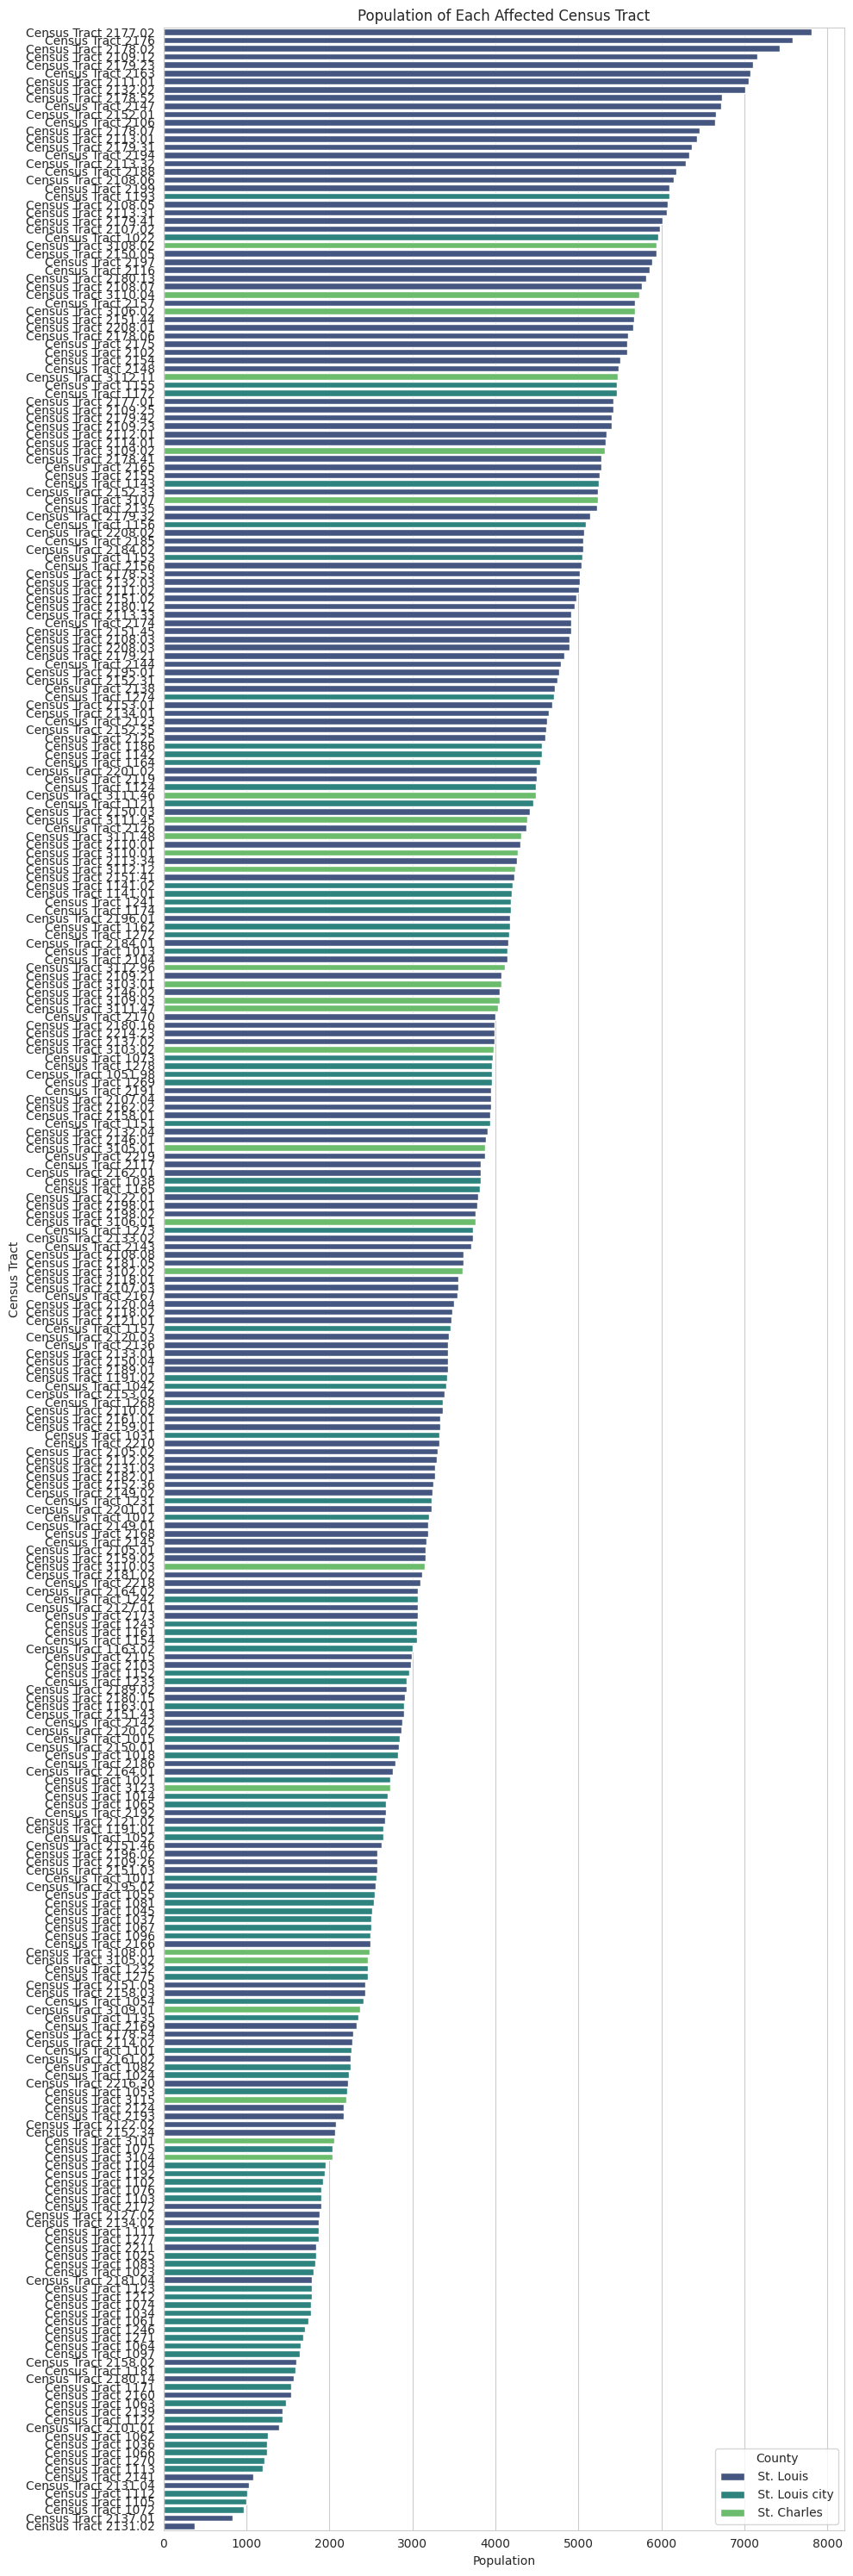

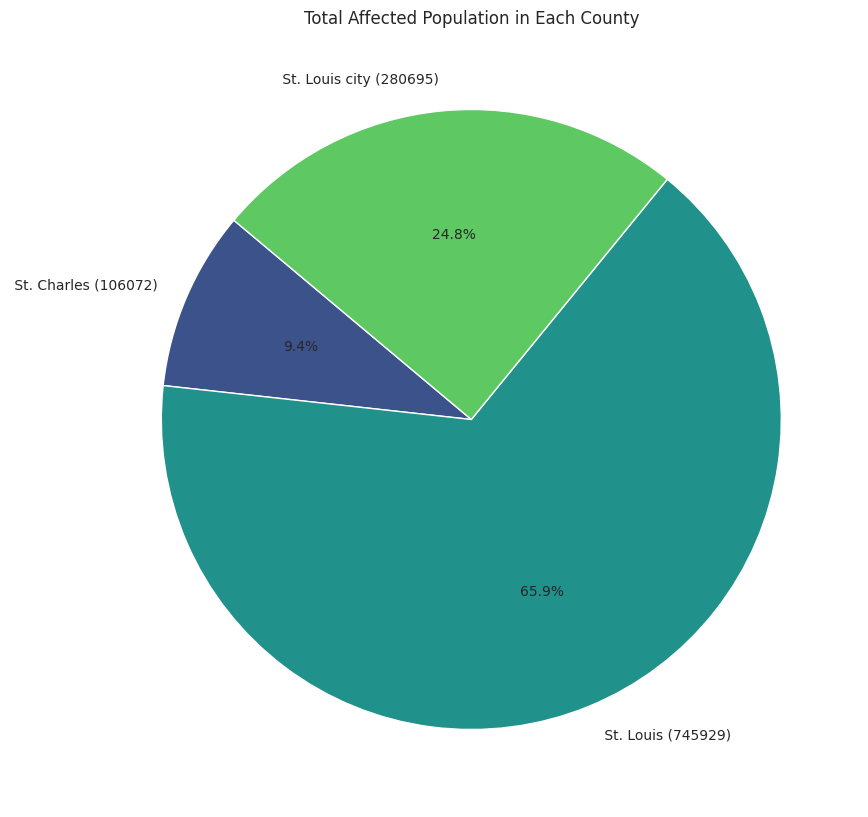

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,30)

# 1. Bar chart for Population of each affected census tract
sns.barplot(data=unique_tracts_affected.sort_values('Population', ascending=False), 
            y='Tract', x='Population', hue='County', dodge=False, palette='viridis')
plt.title('Population of Each Affected Census Tract')
plt.xlabel('Population')
plt.ylabel('Census Tract')
plt.legend(title='County')
plt.tight_layout()
plt.show()

# 2. Pie chart for total affected population in each county
county_population = unique_tracts_affected.groupby('County')['Population'].sum()
colors = sns.color_palette('viridis', len(county_population))
plt.pie(county_population, labels=county_population.index + ' (' + county_population.values.astype(str) + ')',
        colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Total Affected Population in Each County')
plt.show()


## Building Report: Building Amount & Type | Flood Regions

We can also combine the predictive geometries from the flood model with data from OpenStreetMap to identify building polygons in our target area. This allows us to estimate the number of buildings potentially impacted in areas most vulnerable to flooding.

In [6]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Polygon

coordinates = [[-92.79583046462477, 36.713291047659105],
               [-88.35735390212477, 36.713291047659105],
               [-88.35735390212477, 40.01998830501556],
               [-92.79583046462477, 40.01998830501556],
               [-92.79583046462477, 36.713291047659105]]

# Create a Polygon from the coordinates
polygon = Polygon(coordinates)

# Use the osmnx `geometries_from_polygon()` function to get the list of building geometries in the AOI.
buildings = ox.geometries_from_polygon(polygon, tags={'building': True})

# Convert the list of building geometries to a GeoDataFrame.
buildings_gdf = gpd.GeoDataFrame(buildings)
print(f'Total buildings in AOI: {len(buildings_gdf)}')

/var/tmp/ipykernel_4312/2252691958.py:15: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_polygon(polygon, tags={'building': True})


Total buildings in AOI: 347340


In [7]:
# Set CRS for both GeoDataFrames
buildings_gdf = buildings_gdf.set_crs("EPSG:4326")
df_gdf = df_gdf.set_crs("EPSG:4326")

# Filter df_gdf to include only rows with prob_yes > 0.2
high_risk_gdf = df_gdf[df_gdf['prob_yes'] > 0.2]

# Use a spatial join to identify buildings intersecting with flood areas
affected_buildings_gdf = gpd.sjoin(buildings_gdf[['building','geometry']], high_risk_gdf, how="inner", predicate="intersects")
unique_affected_buildings = affected_buildings_gdf.index.unique()
print(f"Number of unique buildings affected: {len(unique_affected_buildings)}")
#print(unique_affected_buildings)

Number of unique buildings affected: 5455


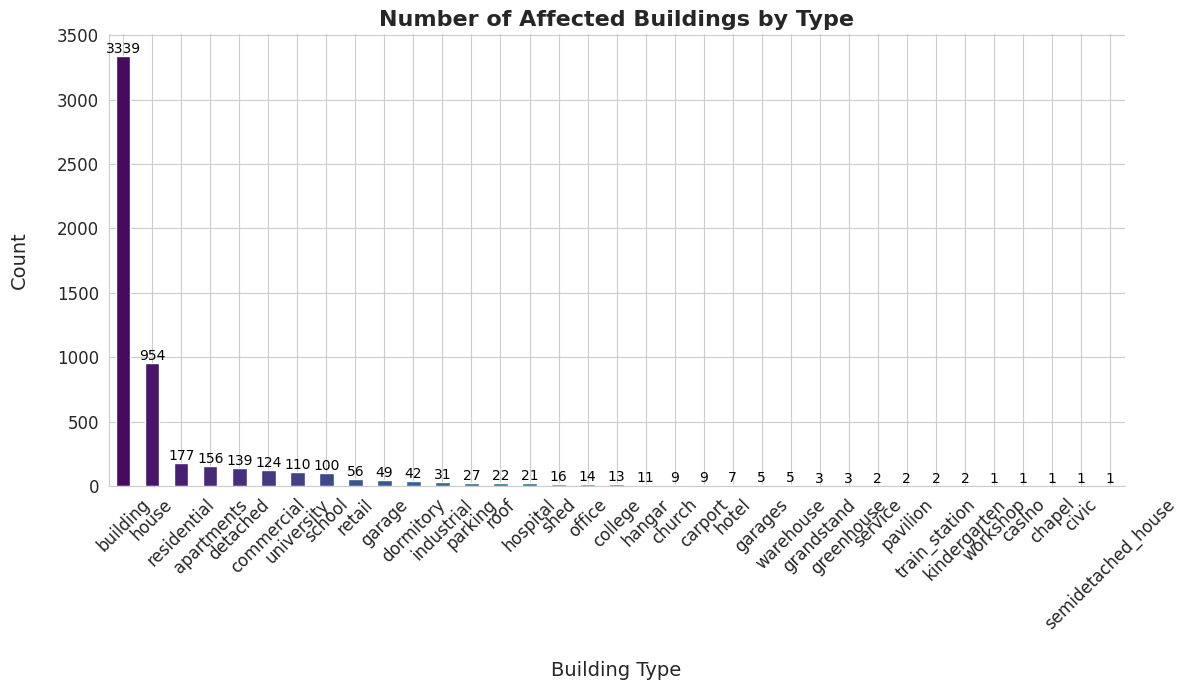

In [8]:
import seaborn as sns

# Drop duplicates based on the 'geometry' column to get unique affected buildings
unique_affected_buildings_gdf = affected_buildings_gdf.drop_duplicates(subset='geometry').copy()

# Set up seaborn style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 7))

# Generate the bar plot with a color palette
unique_affected_buildings_gdf['building'] = unique_affected_buildings_gdf['building'].replace('yes', 'building')
colors = sns.color_palette("viridis", n_colors=unique_affected_buildings_gdf['building'].nunique())
affected_buildings_counts = unique_affected_buildings_gdf['building'].value_counts()
affected_buildings_counts.plot(kind='bar', ax=ax, color=colors)

# Annotate bar heights
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            '{:1.0f}'.format(height),
            ha="center", va='bottom', fontsize=10, color='black')

# Set title and labels with improved fonts
plt.title("Number of Affected Buildings by Type", fontsize=16, fontweight='bold')
plt.xlabel("Building Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

# Remove right and top borders for cleaner look
sns.despine()

plt.tight_layout()
plt.show()
